### Relative Forecasts with `read_relative()`

This notebook demonstrates per-window forecast queries:
1. Creating an overlapping forecast series with multiple `knowledge_time` revisions
2. Reading the globally latest forecast with `read()`
3. Reading the day-ahead forecast with `read_relative(window_length, issue_offset)`

In [1]:
try:
    import google.colab
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/rebase-energy/timedb/main/examples/colab_setup.py',
        '/tmp/colab_setup.py'
    )
    exec(open('/tmp/colab_setup.py').read())
except ImportError:
    pass  # Not running in Google Colab

In [2]:
import timedb as td
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


In [3]:
td.create_series(
    name='wind_forecast',
    unit='MW',
    labels={'model': 'nwp'},
    overlapping=True,
    retention='medium',
)

for s in td.get_series().list_series():
    print(f"  {s['name']}: overlapping={s['overlapping']}  labels={s['labels']}")

  wind_forecast: overlapping=True  labels={'model': 'nwp'}


## Insert Forecast Runs

A wind model issues forecasts twice daily — at 00:00 and 12:00 UTC — over 3 days, each with a 48 h horizon.
Forecast error grows with lead time to simulate a realistic model.

In [4]:
base, horizon = datetime(2025, 1, 1, tzinfo=timezone.utc), 48
np.random.seed(0)
signal = np.clip(80 + 40 * np.sin(2 * np.pi * np.arange(3 * 24 + horizon) / 24 - np.pi / 2), 0, None)

for d, h in [(d, h) for d in range(3) for h in (0, 12)]:
    kt = base + timedelta(days=d, hours=h)
    np.random.seed(10 + d * 10 + h)
    lead = np.arange(horizon)
    td.get_series('wind_forecast').where(model='nwp').insert(
        df=pd.DataFrame({
            'valid_time': [kt + timedelta(hours=int(j)) for j in lead],
            'value': np.round(np.clip(signal[d * 24 + h:d * 24 + h + horizon] + np.random.normal(0, 1 + 0.4 * lead, horizon), 0, None), 2),
        }),
        knowledge_time=kt,
    )

print(f"Inserted 6 forecast runs × {horizon} h horizon")

Inserted 6 forecast runs × 48 h horizon


## Read: Latest vs Day-Ahead

`read()` returns the globally latest forecast for each `valid_time`.

`read_relative()` partitions the time axis into fixed windows and, for each window,
returns the latest forecast with `knowledge_time ≤ window_start + issue_offset`.
With `issue_offset=-12 h`, that means “the last run issued at least 12 h before the window starts” — the day-ahead view.

In [5]:
start_window = base + timedelta(days=1)  # Jan 2 — first window with a full day-ahead forecast

# Globally latest forecast for every valid_time in the series
df_latest = td.get_series('wind_forecast').where(model='nwp').read()

# Day-ahead: per 24 h window, use only forecasts issued ≥ 12 h before the window
df_ahead = td.get_series('wind_forecast').where(model='nwp').read_relative(
    window_length=timedelta(hours=24),
    issue_offset=timedelta(hours=-12),
    start_window=start_window,
)

print(f"read()          → {len(df_latest)} rows  (all valid times, globally latest knowledge_time)")
print(f"read_relative() → {len(df_ahead)} rows  (2 windows × 24 h, day-ahead knowledge_time)")
df_ahead.head(6)

read()          → 108 rows  (all valid times, globally latest knowledge_time)
read_relative() → 84 rows  (2 windows × 24 h, day-ahead knowledge_time)


,value
valid_time,
2025-01-02 00:00:00+00:00,43.41
2025-01-02 01:00:00+00:00,46.03
2025-01-02 02:00:00+00:00,38.37
2025-01-02 03:00:00+00:00,59.11
2025-01-02 04:00:00+00:00,65.53
2025-01-02 05:00:00+00:00,77.95


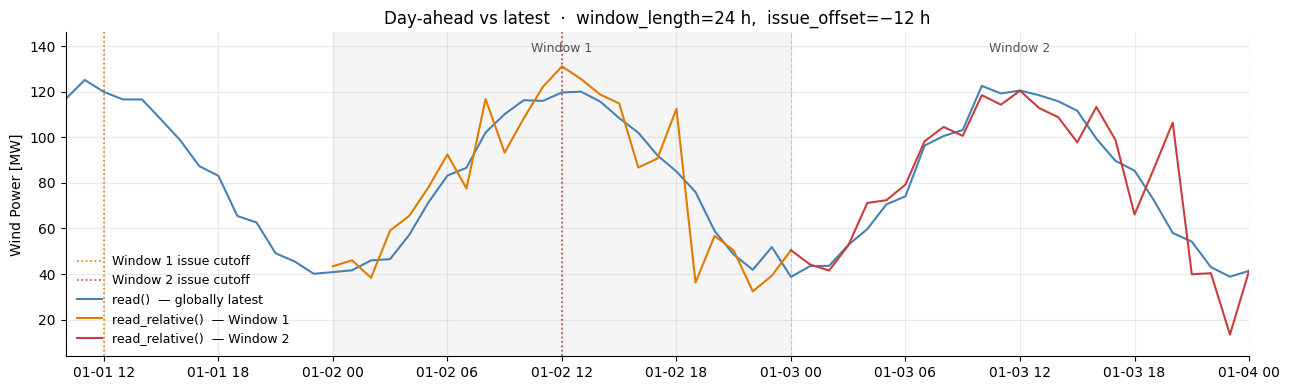

In [6]:
W_COLORS = ['#e07b00', "#c93d3d"]   # orange for Window 1, purple for Window 2
windows = [start_window + timedelta(hours=24 * i) for i in range(2)]

fig, ax = plt.subplots(figsize=(13, 4))

# Window shading, boundary lines, and cutoff vlines
for i, ws in enumerate(windows):
    ax.axvspan(ws, ws + timedelta(hours=24), color=['#f5f5f5', 'white'][i], zorder=0)
    ax.axvline(ws + timedelta(hours=24), color='#ccc', lw=0.8, ls='--', zorder=1)
    ax.axvline(ws - timedelta(hours=12), color=W_COLORS[i], lw=1.2, ls=':', zorder=2,
               label=f'Window {i + 1} issue cutoff')
    ax.text(ws + timedelta(hours=12), 0.97, f'Window {i + 1}',
            transform=ax.get_xaxis_transform(), ha='center', va='top', fontsize=9, color='#555')

# Globally latest forecast (single steelblue line)
ax.plot(df_latest.index, df_latest['value'].astype(float),
        lw=1.5, color='steelblue', label='read()  — globally latest')

# Day-ahead forecast — each window segment colored to match its cutoff
for i, ws in enumerate(windows):
    seg = df_ahead[(df_ahead.index >= ws) & (df_ahead.index <= ws + timedelta(hours=24))]
    ax.plot(seg.index, seg['value'].astype(float),
            lw=1.5, color=W_COLORS[i], label=f'read_relative()  — Window {i + 1}')

# Extend xlim left to show Window 1's cutoff (Jan 1 12:00, 12 h before start_window)
ax.set_xlim(start_window - timedelta(hours=14), start_window + timedelta(hours=48))
ax.set(ylabel='Wind Power [MW]', title='Day-ahead vs latest  ·  window_length=24 h,  issue_offset=−12 h')
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.25)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

### Summary

- `knowledge_time` = when a forecast was issued; `valid_time` = what time it predicts
- `overlapping=True` enables versioned storage — multiple forecasts per `valid_time`
- The orange dotted lines mark the `knowledge_time` cutoff for each window.
  Only runs issued at or before that moment are eligible for `read_relative()`.
